[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jrkasprzyk/CVEN5393/blob/main/streamflow_nowak.ipynb)

*This notebook is part of course notes for CVEN 5393: Water Resource Systems and Management, by Prof. Joseph Kasprzyk at CU Boulder.*

This notebook implements the method published below:

Nowak, K., J. Prairie, B. Rajagopalan, and U. Lall (2010), A nonparametric stochastic approach for multisite
disaggregation of annual to daily streamflow, Water Resour. Res., 46, W08529. [DOI](https://doi.org/10.1029/2009WR008530).

In [77]:
import pandas as pd #for dataframes and data processing
import numpy as np #for numerical computation
import matplotlib.pyplot as plt #for plotting
import sys #system functions
from scipy import interpolate #bring in only the interpolate function
import plotly.express as px #plotly express for fast interactive plotting
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [78]:
def sim_single_year(rng, Z, p, years, sim_Z, print_results=False):

  #inputs:
  #rng - random number generator instance
  #Z - input sequence of aggregated flows
  #p - input 2d array of proportion vectors (disagg timesteps in columns)
  #years - input sequence of years
  #sim_Z - simulated aggregated flow (scalar)
  #print_results - (optional) True for console output, False if not. Default True

  #return: sequence of simulated, disaggregated flow for one year

  # Calculate the distance between the yearly flows and the
  # simulated value
  dist = np.absolute(Z - sim_Z)

  # inds will be the indices of the original sequence in ascending order
  inds = dist.argsort()

  # these are the yearly flows, sorted by their distance from the simulated flow
  sorted_Z = Z[inds]

  # the number of neighbors is a function of the
  # number of datapoints in the yearly sequence
  K = int(np.floor(np.sqrt(len(Z))))

  # the weight function gives the most weight
  # to the first neighbor (eq 1 in the paper)
  W = np.zeros(K)
  for i in range(K):
    W[i] = (1./(i+1.))/sum(1./k for k in range(1, K+1))

  # here, we only keep the K nearest neighbors based on distance
  neighbors = sorted_Z[0:K]
  neighbors_inds = inds[0:K]

  # the index of the closest year...
  chosen_index = rng.choice(neighbors_inds, size=1, p=W)

  # ...is used to find a proportion vector
  sim_p = p[chosen_index, :]

  # the simulated flow sequence is the proportion multiplied by simulated yearly flow
  sim_flow = sim_p * sim_Z

  if print_results is True:
    print(f"Sim annual {sim_Z: 0.1f}, \
    using analog year {str(*years[chosen_index])}: \
    {np.array2string(sim_flow, precision=1, floatmode='fixed')}")

  return sim_flow

In [90]:
def sim_multi_trace(rng, Z, p, years, sim_Z, repl=1, print_results=False):
  #inputs:
  #rng - random number generator instance
  #Z - input sequence of aggregated flows
  #p - input 2d array of proportion vectors (years in rows, periods in columns)
  #years - input sequence of years
  #mat_Z - simulated aggregated flow (sequences in rows, years in columns)
  #repl - (optional) number of replicates per simulated annual sequence. Default 1
  #print_results - (optional) True for console output, False if not. Default True

  #return: sequence of simulated, disaggregated flow for one year

  # what is the shape of the proportion matrix, p?
  num_input_years, num_periods = p.shape

  # what is the shape of the simulated annual data?
  num_seq, num_sim_years = sim_Z.shape

  # the output matrix will have the following shape:
  # rows: number of disaggregated periods * number of simulated years
  # columns: number of annual sequences * number of replicates
  #
  # example: seasonal data (4x per year), for sequences of 3 years: 12 rows
  # 5 annual sequences, each repeated twice: 10 columns
  mat_sim = np.zeros((num_periods*num_sim_years, num_seq*repl))

  j = 0 #column for the final output
  for r in range(repl): # repeat for 2 replicates
    for s in range(num_seq): # multiple sequences
      i = 0 # row for the final output
      for y in range(num_sim_years): # multiple years
        sim_seas = sim_single_year(rng, Z, p, years, sim_Z[s, y])
        mat_sim[i:i+num_periods, j] = sim_seas
        i = i+num_periods
      j = j+1

  return mat_sim

# Example 1: Perform one disaggregation given a simulated Z value (from the paper)

In [91]:
ex1_rng = np.random.default_rng(seed=42)

ex1_obs_years = np.array([1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975])
ex1_obs_ann_flow = np.array([35., 40., 33., 52., 43., 56., 38., 49., 32.])
ex1_obs_p = np.array(
    [[.1, .3, .4, .2],
     [.15, .25, .35, .25],
     [.1, .2, .5, .2],
     [.5, .15, .65, .15],
     [.2, .2, .4, .2],
     [.1, .2, .4, .3],
     [.15, .2, .4, .25],
     [.05, .1, .8, .05],
     [.2, .2, .5, .1]
     ]
    )

ex1_sim_ann_flow = 70.

Below, we perform the simulation 10 different times. The algorithm has one component of randomness: a random number is used to generate which analog year is chosen. Therefore, repeating the simulation multiple times will create new timeseries, since different analog years have different proportion vectors.

In [92]:
# 10 different simulations for the same annual flow
for i in range(10):
  ex1_sim_seas_flow = sim_single_year(ex1_rng, ex1_obs_ann_flow, ex1_obs_p, ex1_obs_years, ex1_sim_ann_flow, print_results=True)

Sim annual  70.0,     using analog year 1970:     [[35.0 10.5 45.5 10.5]]
Sim annual  70.0,     using analog year 1972:     [[ 7.0 14.0 28.0 21.0]]
Sim annual  70.0,     using analog year 1974:     [[ 3.5  7.0 56.0  3.5]]
Sim annual  70.0,     using analog year 1970:     [[35.0 10.5 45.5 10.5]]
Sim annual  70.0,     using analog year 1972:     [[ 7.0 14.0 28.0 21.0]]
Sim annual  70.0,     using analog year 1974:     [[ 3.5  7.0 56.0  3.5]]
Sim annual  70.0,     using analog year 1970:     [[35.0 10.5 45.5 10.5]]
Sim annual  70.0,     using analog year 1970:     [[35.0 10.5 45.5 10.5]]
Sim annual  70.0,     using analog year 1972:     [[ 7.0 14.0 28.0 21.0]]
Sim annual  70.0,     using analog year 1972:     [[ 7.0 14.0 28.0 21.0]]


# Example 2: Seasonal flow with reservoir simulation

*This is a new illustrative example for Spring 2024, written by Prof. Kasprzyk. It maintains four timesteps per year but uses more data with more questions to answer.*

A particular river has observed seasonal streamflow (af) from 2000-2007. A climate model has been used to create 5 different synthetic sequences of new annual flows, each of which is 3 years long.

Use the Nowak et al disaggregation method to create synthetic sequences of 3 years' worth of seasonal data. For each annual sequence provided, repeat the process 2 times to create random disaggregated seuqences from each annual sequence.

When you're done, you should have 10 new seasonal sequences!


In [83]:
ex2_obs_years = np.array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])

# shape: an array with seasonal flow starting in 2000 and ending in 2007
ex2_obs_seas_flow = np.array([50., 52., 80., 105., 60., 70., 90., 110.,
                              60., 24., 40., 80., 40., 30., 80., 92.,
                              81., 55., 81., 92., 50., 60., 100., 150.,
                              20., 10., 80., 100., 50., 20., 30., 120.])

# shape: sequences in rows; years in columns
ex2_sim_ann_flow = np.array([[275., 300., 305],
                             [200., 220., 400.],
                             [300., 310., 289.],
                             [260., 311., 400.],
                             [200., 250., 260.]])

In this example, all we have started with is the seasonal flow, in other words this is the observed disaggregated flow. We must calculate the proportion vector as well as find the observed annual flow.

We will also be performing the calculations over multiple timesteps, using three different sequences of simulated annual data.

In [93]:
# create a matrix with 8 rows (years) and 4 columns (seasons)
ex2_obs_seas_flow_mat = ex2_obs_seas_flow.reshape((8, 4))

# find the sum of each row, which is the observed annual flow
ex2_obs_ann_flow = np.sum(ex2_obs_seas_flow_mat, axis=1)

# prepare the variable for the proportion vector
ex2_obs_p = np.zeros((8, 4))

# calculate the proportion vector
for i in range(4):
  ex2_obs_p[:, i] = ex2_obs_seas_flow_mat[:, i]/ex2_obs_ann_flow

Now the observed data is the same format as Example 1. When running the calculations for this problem, though, we will need to store them in a larger format since we are doing one calculation for every simulated annual flow, and repeating it with multiple replicates.

In [94]:
# reset the random number generator to produce consistent results for this example
ex2_rng = np.random.default_rng(seed=42)

ex2_sim_seas_flow = sim_multi_trace(ex2_rng, ex2_obs_ann_flow, ex2_obs_p, ex2_obs_years, ex2_sim_ann_flow, repl=2, print_results=False)

Converting the results to a data frame provides some easy ways to analyze.

In [95]:
my_df = pd.DataFrame(ex2_sim_seas_flow)

<Axes: >

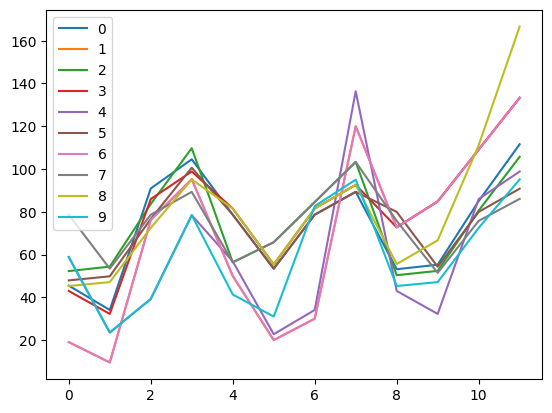

In [98]:
my_df.plot()

Ideas for future updates:


*   Demonstrate how to input an Excel spreadsheet to do the analysis here
*   Demonstrate an example of more than 4 periods per year
*   Add a spatial example -- refactor functions to refer more generically to aggregated value Z and disaggregated value x

